In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import copy
import itertools
import os
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS


In [3]:
fitness_df = utils.load_fitness_data()
print(fitness_df.columns)
fitness_df.head()

Index(['Index', 'src_file', 'game_name', 'domain_name',
       'all_variables_defined', 'all_variables_used', 'all_preferences_used',
       'setup_objects_used', 'no_adjacent_once', 'starts_and_ends_once',
       'variable_not_repeated', 'no_nested_logicals', 'pref_forall_correct',
       'correct_predicate_arity', 'real', 'original_game_name'],
      dtype='object')


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,correct_predicate_arity,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,1.0,1.0,1.0,1.0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,1.0,1.0,1.0,1.0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,1.0,1.0,1.0,1.0,True,614dec67f6eb129c3a77defd-6


In [4]:
def base_syntethic_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('ast-mle-samples.pddl', 'ast-mle-regrowth-samples.pddl')) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    if 'ast-mle-samples.pddl' in synthetic_data_src_files:
        syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'original_game_name'] = syntethic_df.loc[syntethic_df.src_file == 'ast-mle-samples.pddl', 'game_name']

    return syntethic_df

syntethic_fitness_df = base_syntethic_df(fitness_df)

In [5]:
syntethic_fitness_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,variable_not_repeated,no_nested_logicals,pref_forall_correct,correct_predicate_arity,real,original_game_name
0,98,ast-mle-samples.pddl,game-id-0,medium-objects-room-v1,1.0,0.750000,1.000000,0.0,0.5,0.0,0.818182,0.821429,0.666667,0.409091,False,game-id-0
1,99,ast-mle-samples.pddl,game-id-1,medium-objects-room-v1,1.0,0.600000,1.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.400000,False,game-id-1
2,100,ast-mle-samples.pddl,game-id-2,many-objects-room-v1,1.0,0.750000,1.000000,0.0,1.0,0.0,0.500000,0.846154,0.000000,0.333333,False,game-id-2
3,101,ast-mle-samples.pddl,game-id-3,many-objects-room-v1,1.0,0.375000,0.333333,1.0,1.0,0.0,0.666667,0.750000,0.000000,0.500000,False,game-id-3
4,102,ast-mle-samples.pddl,game-id-4,few-objects-room-v1,1.0,0.666667,1.000000,0.0,1.0,0.0,1.000000,1.000000,1.000000,1.000000,False,game-id-4


In [ ]:
fake_games = syntethic_fitness_df[syntethic_fitness_df.src_file == 'ast-mle-regrowth-samples.pddl'].reset_index()
broadcasted_original = syntethic_fitness_df.loc[[syntethic_fitness_df.index[(syntethic_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0
for column in original_regrown_diffs.columns:
    if column in ('index', 'Index', 'real'):
        continue

    ax = axes[index // 5][index % 5]
    ax.hist(original_regrown_diffs[column], bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()
unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

Trying a similar process, but taking the max feature value for each original game

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

original_games = syntethic_fitness_df.original_game_name.unique()

for column in syntethic_fitness_df.columns:
    if column in utils.NON_FEATURE_COLUMNS:
        continue

    diffs = []
    for original_game in original_games:
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][column]
        argmax = game_col.argmax()
        diffs.append((game_col - game_col.iloc[argmax])[game_col.index != game_col.index[argmax]].values)
        
    diffs = np.concatenate(diffs)

    ax = axes[index // 5][index % 5]
    ax.hist(diffs, bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

original_games = syntethic_fitness_df.original_game_name.unique()
key_column = 'setup_objects_used'

game_idxmaxes = syntethic_fitness_df.groupby('original_game_name')[key_column].idxmax()


for column in syntethic_fitness_df.columns:
    if column in utils.NON_FEATURE_COLUMNS:
        continue

    diffs = []
    for original_game in original_games:
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][column]
        game_idxmax = game_idxmaxes[original_game]
        diffs.append((game_col - game_col.loc[game_idxmax])[game_col.index != game_idxmax].values)
        
    diffs = np.concatenate(diffs)

    ax = axes[index // 5][index % 5]
    ax.hist(diffs, bins=20)
    ax.set_title(f'{column} diffs')
    index += 1

plt.show()

# Synthetic experiment approach
* Pick one feature value that is the 'target' feature for this experiment
* For each set of games generated from the same 'source' synthetic game:
    * Find the game in that set that has the highest value on that feature
    * Define that game to the be positive game for the recovery experiment with this feature; treat the remaining games as the negatives. 
* At this point, we have a single designated positive game from each set. 
* Fit the fitness model with these labels.
* Check whether or not the highest coefficient belongs to the feature picked initially.
* Repeat for other features, and potentially for feature combinations


In [6]:
def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str], \
    param_grid: typing.Dict[str, typing.Any],
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None, n_folds: int = 5):

    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(model_kwargs=model_kwargs, train_kwargs=train_kwargs))])

    param_grid['fitness__n_features'] = [len(feature_columns)]
    random_seed = train_kwargs['random_seed'] if train_kwargs is not None and 'random_seed' in train_kwargs else None

    cv = GridSearchCV(pipeline, param_grid, scoring=scoring_function, cv=KFold(n_folds, shuffle=True, random_state=random_seed), n_jobs=-1, verbose=0)
    cv.fit(train_tensor, None)
    return cv


def single_feature_parameter_recovery_experiment(df: pd.DataFrame, target_feature: str, 
    param_grid: typing.Dict[str, typing.Any], target_feature_epsilon: float = 0,
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    syntethic_fitness_df = base_syntethic_df(df)

    if feature_columns is None:
        feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
    elif target_feature not in feature_columns:
        raise ValueError(f'Target feature {target_feature} not in feature_columns')

    rng = np.random.default_rng(random_seed)

    game_idxmaxes = []
    for original_game in syntethic_fitness_df.original_game_name.unique():
        game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][target_feature]
        idx = rng.choice(np.argwhere(game_col.values == game_col.values.max()).reshape(-1))
        game_idxmaxes.append(game_col.index[idx])

    syntethic_fitness_df.real = 0
    syntethic_fitness_df.loc[game_idxmaxes, 'real'] = 1
    syntethic_fitness_df.loc[game_idxmaxes, target_feature] += target_feature_epsilon

    feature_group_by = syntethic_fitness_df.groupby('original_game_name')[target_feature].max()

    for i, original_game in enumerate(syntethic_fitness_df.original_game_name.unique()):
        assert(feature_group_by[original_game] == syntethic_fitness_df.loc[game_idxmaxes[i], target_feature])

    train_df, test_df = utils.train_test_split_by_game_name(syntethic_fitness_df, random_seed=random_seed)
    cv = cross_validate(train_df, feature_columns, param_grid, scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, model_kwargs=model_kwargs)
    best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore
    weights = best_model.fc1.weight.detach().numpy().reshape(-1)

    target_feature_index = feature_columns.index(target_feature)
    target_feature_is_max_weight = weights.argmax() == target_feature_index
    target_feature_weight_diff = weights[target_feature_index] - weights[np.arange(len(weights)) != target_feature_index].max()
    return {
        'target_feature': target_feature,
        'random_seed': random_seed,
        'is_max_weight': target_feature_is_max_weight,
        'weight_diff': target_feature_weight_diff,
        'best_params': cv.best_params_,
        'best_score': cv.best_score_,
        'target_feature_epsilon': target_feature_epsilon,
    }
    
    


In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

results_by_feature = defaultdict(list)
all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
pbar = tqdm.tqdm(total=len(all_feature_columns) * N_SEEDS)

for target_feature in all_feature_columns:
    pbar.set_description(f'Feature {target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        results_by_feature[target_feature].append(single_feature_parameter_recovery_experiment(syntethic_fitness_df, target_feature, test_param_grid, random_seed=seed))
        pbar.update(1)


In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
index = 0

for target_feature in results_by_feature:
    results = results_by_feature[target_feature]
    weight_diffs = [r['weight_diff'] for r in results]
    ax = axes[index // 5][index % 5]
    ax.hist(weight_diffs, bins=5)
    ax.set_title(f'{target_feature} weight diffs\nP(max) = {np.mean([r["is_max_weight"] for r in results]):.2f}')
    ax.set_xlabel(f'Weight diff (target - max(others))')
    ax.set_ylabel('Count')
    index += 1

plt.subplots_adjust(hspace=0.35)
plt.show()

In [7]:
def single_two_feature_parameter_recovery_experiment(df: pd.DataFrame, 
    positive_target_feature: str, negative_target_feature: str,
    param_grid: typing.Dict[str, typing.Any], target_feature_epsilon: float = 0,
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}
    
    syntethic_fitness_df = base_syntethic_df(df)

    if feature_columns is None:
        feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
    elif positive_target_feature not in feature_columns:
        raise ValueError(f'Positive target feature {positive_target_feature} not in feature_columns')
    elif negative_target_feature not in feature_columns:
        raise ValueError(f'Negative target feature {negative_target_feature} not in feature_columns')

    rng = np.random.default_rng(random_seed)

    unique_games = list(syntethic_fitness_df.original_game_name.unique())

    game_idxmaxes = []
    game_values = []
    for original_game in unique_games:
        pos_game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][positive_target_feature]
        neg_game_col = syntethic_fitness_df[syntethic_fitness_df.original_game_name == original_game][negative_target_feature]
        diff = pos_game_col - neg_game_col
        idx = rng.choice(np.argwhere(diff.values == diff.values.max()).reshape(-1))
        game_idxmaxes.append(pos_game_col.index[idx])
        game_values.append(diff.values.max())

    syntethic_fitness_df.real = 0
    syntethic_fitness_df.loc[game_idxmaxes, 'real'] = 1
    syntethic_fitness_df.loc[game_idxmaxes, positive_target_feature] += target_feature_epsilon
    syntethic_fitness_df.loc[game_idxmaxes, negative_target_feature] -= target_feature_epsilon

    feature_combination_group_by = syntethic_fitness_df.groupby('original_game_name').apply(lambda df: df[positive_target_feature] - df[negative_target_feature]).groupby('original_game_name').max()
    
    for i, original_game in enumerate(unique_games):
        assert(feature_combination_group_by[original_game] == (syntethic_fitness_df.loc[game_idxmaxes[i], positive_target_feature] - syntethic_fitness_df.loc[game_idxmaxes[i], negative_target_feature]))  # type: ignore

    train_df, test_df = utils.train_test_split_by_game_name(syntethic_fitness_df, random_seed=random_seed)
    cv = cross_validate(train_df, feature_columns, param_grid, scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, model_kwargs=model_kwargs)
    best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore
    weights = best_model.fc1.weight.detach().numpy().reshape(-1)

    pos_target_feature_index = feature_columns.index(positive_target_feature)
    pos_target_feature_is_max_weight = weights.argmax() == pos_target_feature_index
    pos_target_feature_is_min_weight = weights.argmin() == pos_target_feature_index
    pos_target_feature_weight_diff = weights[pos_target_feature_index] - weights[np.arange(len(weights)) != pos_target_feature_index].max()

    neg_target_feature_index = feature_columns.index(negative_target_feature)
    neg_target_feature_is_max_weight = weights.argmax() == neg_target_feature_index
    neg_target_feature_is_min_weight = weights.argmin() == neg_target_feature_index
    neg_target_feature_weight_diff = weights[neg_target_feature_index] - weights[np.arange(len(weights)) != neg_target_feature_index].min()

    return {
        'pos_target_feature': positive_target_feature,
        'neg_target_feature': negative_target_feature,
        'random_seed': random_seed,
        'pos_is_max_weight': pos_target_feature_is_max_weight,
        'pos_is_min_weight': pos_target_feature_is_min_weight,
        'pos_weight_diff': pos_target_feature_weight_diff,
        'neg_is_max_weight': neg_target_feature_is_max_weight,
        'neg_is_min_weight': neg_target_feature_is_min_weight,
        'neg_weight_diff': neg_target_feature_weight_diff,
        'best_params': cv.best_params_,
        'best_score': cv.best_score_,
        'target_feature_epsilon': target_feature_epsilon,
    }
    

DEFAULT_LEGEND_KWARGS = dict(loc='upper left', bbox_to_anchor=(1.05, 1.35))
DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(hspace=0.35)
    
def plot_two_feature_parameter_recovery_experiment_results(
    results_by_feature: typing.Dict[typing.Tuple[str, str], typing.List[typing.Dict[str, typing.Any]]], 
    feature_columns: typing.List[str], flip_features: bool = False,
    layout: typing.Tuple[int, int] = (2, 5), figsize: typing.Tuple[int, int] = (20, 10),
    title: typing.Optional[str] = None, colormap: str = 'tab10',
    legend_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LEGEND_KWARGS,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    ):

    cmap = plt.get_cmap(colormap)  # type: ignore
    fig, axes = plt.subplots(*layout, figsize=figsize)
    index = 0

    for target_feature in feature_columns:
        positive_keys = [k for k in results_by_feature.keys() if k[0] == target_feature]
        negative_keys = [k for k in results_by_feature.keys() if k[1] == target_feature]

        positive_results = [results_by_feature[k] for k in positive_keys]
        negative_results = [results_by_feature[k] for k in negative_keys]

        positive_weight_diffs = [r['pos_weight_diff'] for r in itertools.chain(*positive_results)]
        negative_weight_diffs = [r['neg_weight_diff'] for r in itertools.chain(*negative_results)]

        if flip_features:
            max_key = 'neg_is_max_weight'
            min_key = 'pos_is_min_weight'
        else:
            max_key = 'pos_is_max_weight'
            min_key = 'neg_is_min_weight'

        feature_is_max_weight = [r[max_key] for r in itertools.chain(*positive_results)]
        feature_is_min_weight = [r[min_key] for r in itertools.chain(*negative_results)]

        ax = axes[index // 5][index % 5]
        positive_color, negative_color = cmap(0), cmap(1)
        if flip_features:
            positive_color, negative_color = negative_color, positive_color

        ax.hist(positive_weight_diffs, color=positive_color, label='Positive feature\nregression weight')
        ax.hist(negative_weight_diffs, color=negative_color, label='Negative feature\nregression weight')

        max_mean, min_mean = np.mean(feature_is_max_weight), np.mean(feature_is_min_weight)
        ax.set_title(f'{target_feature} weight diffs\nP(min) = {min_mean:.2f} | P(max) = {max_mean:.2f}')
        ax.set_xlabel(f'Weight diff (target - max/min(others))')
        ax.set_ylabel('Count')
        index += 1

    if title:
        fig.suptitle(title)

    plt.legend(**legend_kwargs)
    plt.subplots_adjust(**subplot_adjust_params)
    plt.show()

In [ ]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]

two_feature_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed))


In [ ]:
plot_two_feature_parameter_recovery_experiment_results(two_feature_results_by_feature, all_feature_columns)

In [8]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,],
    'fitness__margin': [1, 2, 4],   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_hinge_loss}

two_feature_hinge_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_hinge_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


  0%|          | 0/90 [00:00<?, ?it/s]

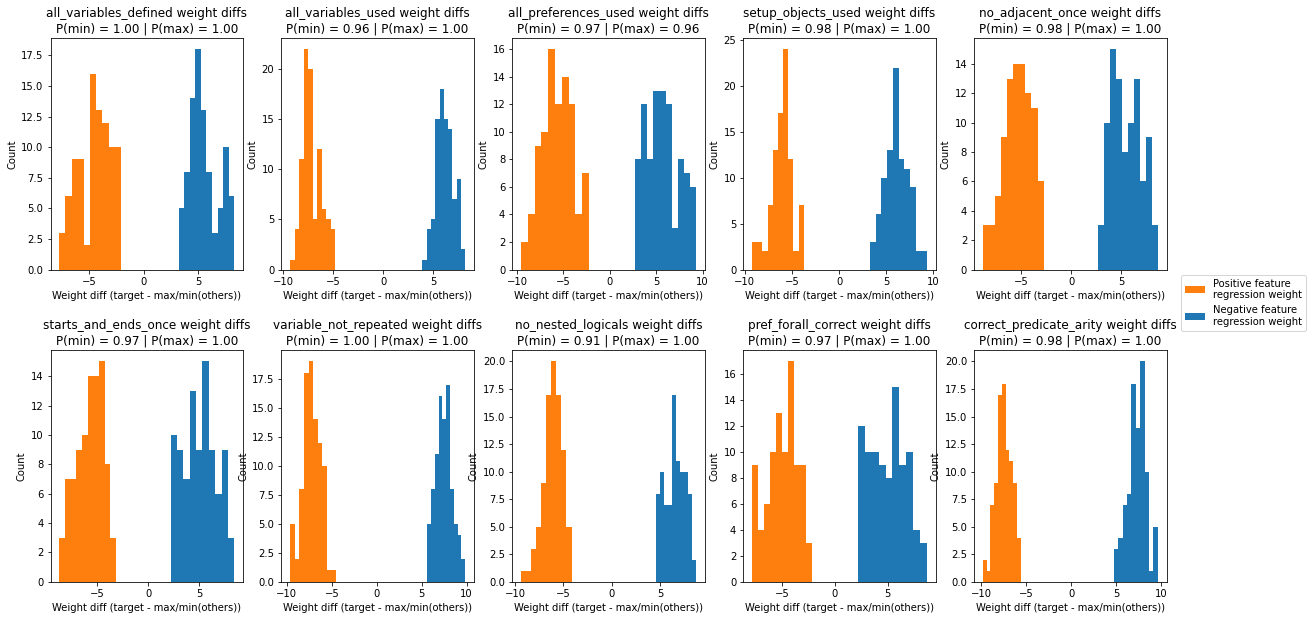

In [14]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_hinge_loss_results_by_feature, all_feature_columns, flip_features=True,
)

In [10]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,]   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_log_loss}

two_feature_log_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_log_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


  0%|          | 0/90 [00:00<?, ?it/s]

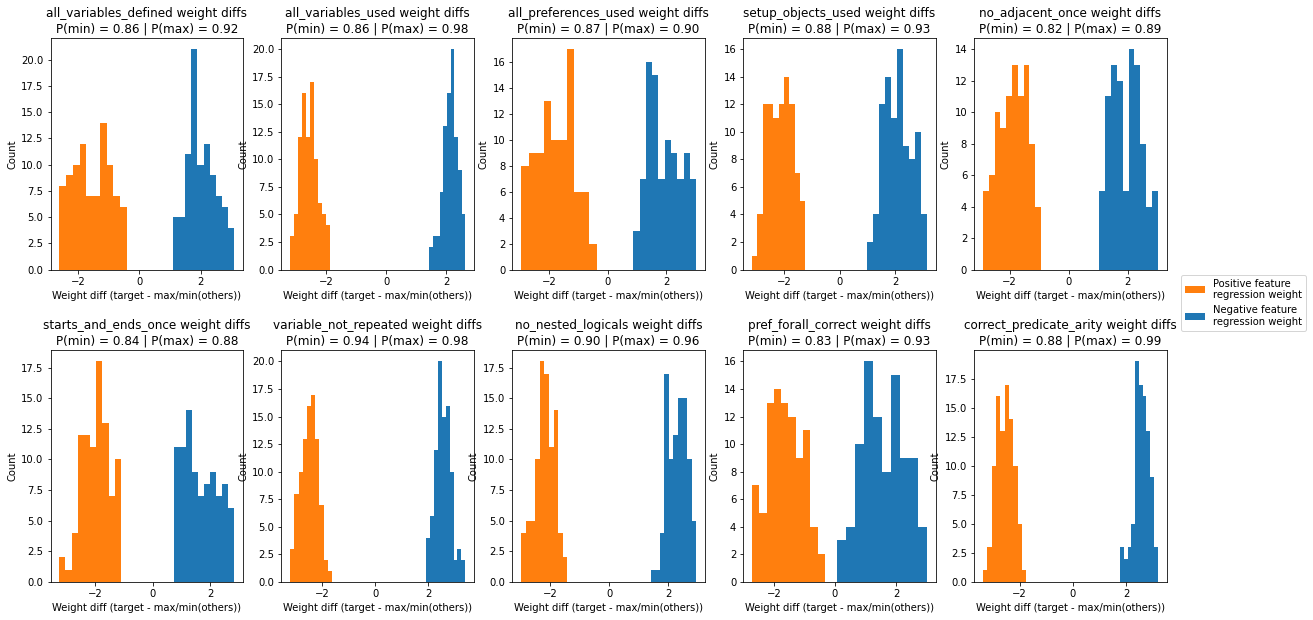

In [11]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_log_loss_results_by_feature, all_feature_columns, flip_features=True,
)

In [12]:
test_param_grid = {
    'fitness__n_outputs': [1], 
    'fitness__weight_decay': [0.0, 0.01, 0.05, 0.1], 
    'fitness__hidden_size': [None,],
    'fitness__margin': [1, 2, 4],   
}

N_SEEDS = 10
START_SEED = utils.DEFAULT_RANDOM_SEED

all_feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = {'output_activation': nn.Identity()}
train_kwargs = {'loss_function': utils.fitness_square_square_loss}

two_feature_square_square_loss_results_by_feature = defaultdict(list)
pbar = tqdm.tqdm(list(itertools.permutations(all_feature_columns, 2)))
for positive_target_feature, negative_target_feature in pbar:
    pbar.set_description(f'Processing {positive_target_feature} - {negative_target_feature}')
    for seed in range(START_SEED, START_SEED + N_SEEDS):
        two_feature_square_square_loss_results_by_feature[(positive_target_feature, negative_target_feature)].append(single_two_feature_parameter_recovery_experiment(
            syntethic_fitness_df, positive_target_feature, negative_target_feature, test_param_grid, random_seed=seed, 
            scoring_function=utils.evaluate_fitness_flipped_sign, model_kwargs=model_kwargs, train_kwargs=train_kwargs))


  0%|          | 0/90 [00:00<?, ?it/s]

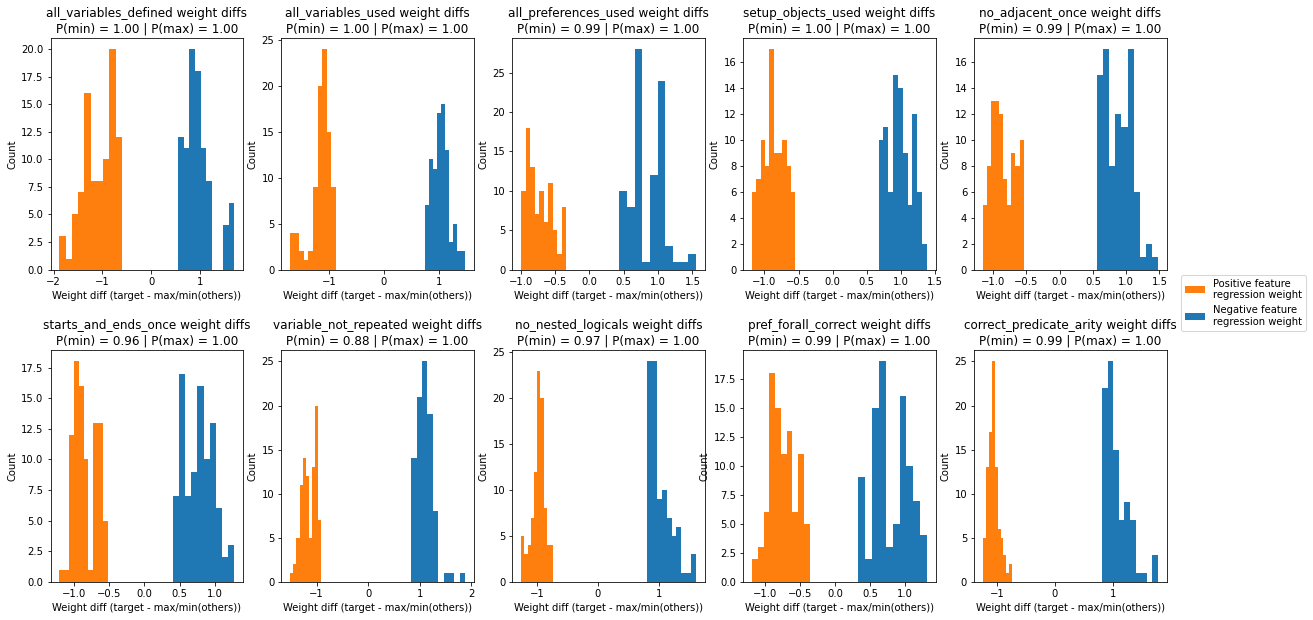

In [15]:
plot_two_feature_parameter_recovery_experiment_results(
    two_feature_square_square_loss_results_by_feature, all_feature_columns, flip_features=True,
)

## Debugging thoughts about these new losses
* Plot my loss implementations to make sure they behave as expected
* Verify my scoring function works and the model returned is actually the best one
* Try the square-square loss as well
* Cross validate over other margins?